# Automated Trading Strategy - Moving Average Crossover

## Automated Trading Strategy
In this interactive python notebook we implement a moving average crossover trading strategy sourcing data dynamically from **yahoo finance!**.  Using a pandas DataFrame we run the strategy by firstly initializing moving average indicators for a given short and long moving average indicator. Secondly we inspect the indicator date for moving average crossovers and record the signal +1 for a buy and -1 for a sell signal. Third we convert the signal into a position ensuring to close out the final position to capture the backtest statistics accurately. Forthly we compute the log returns of a passive benchmark and for the moving average crossover strategy.

## Strategy OOP Toolkit
Additionally we have implemented an **optimize** method to search for the optimal short and long moving average parameters. We also have methods to **show** the DataFrame data and to **plot**. The **compare** method plots and compares the benchmark versus the trading strategy performance. Finally the **analysis** method computes extensive and detailed performance metrics using the Python **quantstats** module, which gives detailed performance, drawdown, sharpe ratio and other useful results metrics. The analysis also includes underwater charts and performance heatmaps.

## Multi-Equity Strategy Optimization
We demonstrate the strategy on a single US tech stock and on a basket of tech stocks. For the equity basket we search for equity strategy that produces the best returns. We optimize the best strategy further for the best model parameters and produce an extensive performance analysis.

In [1]:
# Import Modules
import os
import pandas as pd
import yfinance as yf
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

# Magic function to enable matplotlib charting in jupyter notebooks
%matplotlib inline

# Allow Cell Multi Printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

# Backtest Trading Strategy - Moving Average CrossOver

In [2]:
# Class: Moving Average CrossOver
class MACrossOver:
    
    def __init__(self, ticker, startDate, endDate, shortDays, longDays, useExp=True):
        
        # Member Data
        self.ticker = ticker
        self.startDate = startDate
        self.endDate = endDate
        self.shortDays = shortDays
        self.longDays = longDays
        
        # Moving Average Parameters (Before Optimization)
        self.originalShortDays = self.shortDays
        self.originalLongDays = self.longDays
        
        # use exponential average else simple average
        self.useExp = useExp
        self.averagingType = "Exponential Moving Averages" if self.useExp else "Simple Moving Averages"
        
        # Call Trading Strategy Methods
        self.downloadData()
        self.runStrategy()
        
        # Print Total Return
        print(f"{self.ticker} Total Return:  {self.totalReturn}")
    
    def downloadData(self):
        print(f"Downloading Data from Yahoo Finance for {self.ticker}")
        self.df = yf.download(self.ticker, self.startDate, self.endDate)

    def runStrategy(self):
        self.indicators()
        self.signals()
        self.positions()
        self.returns()
        
    def indicators(self):
        
        if (self.useExp):
            #Exponential Moving Average
            self.df["SMA"] = self.df["Adj Close"].ewm(span=self.shortDays, adjust=False).mean()
            self.df["LMA"] = self.df["Adj Close"].ewm(span=self.longDays, adjust=False).mean()
        else:
            # Simple Moving Average
            self.df["SMA"] = self.df["Adj Close"].rolling(window=self.shortDays, center=False).mean()
            self.df["LMA"] = self.df["Adj Close"].rolling(window=self.longDays, center=False).mean()

        # Track Previous Values    
        self.df["SMA_PREV"] = self.df["SMA"].shift()
        self.df["LMA_PREV"] = self.df["LMA"].shift()
        
    def signals(self):
        # Mark Buy Crossover Signal as +1
        self.df["Signal"] = np.where((self.df["SMA"] > self.df["LMA"]) 
                            & (self.df["SMA_PREV"] < self.df["LMA_PREV"]), 1, 0)
        # Mark Sell Crossover Signal as -1
        self.df["Signal"] = np.where((self.df["SMA"] < self.df["LMA"]) 
                            & (self.df["SMA_PREV"] > self.df["LMA_PREV"]), -1, self.df["Signal"])
    
    def signalCount(self):
        # Print Number of Signals
        statistics = self.df["Signal"].value_counts()
        print(f"{self.ticker}: {statistics}")
        
    def positions(self):
        # Copy Signal and replace zero signals by propagating forward the last signal i.e. forward fill
        self.df["Position"] = self.df["Signal"].replace(to_replace=0, method="ffill")
        
        # Close-Out final position
        self.df["Position"][-1] = 0
    
    def returns(self):
        self.df["Passive_Returns"] = np.log(self.df["Adj Close"] / self.df["Adj Close"].shift(1))
        self.df["Strategy_Returns"] = self.df["Passive_Returns"] * self.df["Position"].shift(1)
        self.totalReturn = np.round(self.df["Strategy_Returns"].cumsum()[-1],2)
        return self.totalReturn

    def optimize(self, shortDayList=[2,3,4,5,6,7,8,9,10], longDayList=[10,11,12,13,14,15,16,17,18,20,25,30,35,40,45,50], useOptimalParams=True):
        
        print(f"*** Searching for Optimal Results ***")
        
        bestReturn = -999
        bestShortDays = 0
        bestLongDays = 0
        
        # Track Original Moving Average Parameters
        self.originalShortDays = self.shortDays
        self.originalLongDays = self.longDays
        
        # Iterate over shortDay- and longDayLists to final optimal parameters
        for shortDays in shortDayList:
            for longDays in longDayList:
                
                # Update Moving Average Parameters
                self.shortDays = shortDays
                self.longDays = longDays
                
                # Run the Strategy with the New Parameters
                self.runStrategy()
                thisReturn = self.totalReturn 
                
                # Print Iteration Results
                print(f"ShortDays: {shortDays}, LongDays: {longDays}, Total Return: {thisReturn}")
                
                # Track Best Parameters
                if  thisReturn > bestReturn:
                    bestReturn = thisReturn
                    bestShortDays = self.shortDays
                    bestLongDays = self.longDays
        
        # Set Best Moving Average Parameters
        self.shortDays = bestShortDays
        self.longDays = bestLongDays

        # Use Optimal Parameters if requested 
        if (useOptimalParams == False):
            
            # If requested, restore Original Moving Average Parameters
            self.shortDays = self.originalShortDays
            self.longDays = self.originalLongDays
        
        # Restore Underlying Strategy Data, o.w. data from last iteration will persist
        self.runStrategy()
        
        print()
        print(f"*** Strategy Optimization Results ***")
        print(f"Best Short Days: {bestShortDays}")
        print(f"Best Short Days: {bestLongDays}")
        print(f"UseOptimalParameters: {useOptimalParams}")
        print(f"Averaging Type: {self.averagingType}")
        print(f"Strategy Settings - Moving Average Short Days: {self.shortDays}")
        print(f"Strategy Settings - Moving Average Long Days: {self.longDays}")
        print(f"Total Return: {self.totalReturn}")
    
    def restore(self):
        # Restore Strategy to Pre-Optimized State
        self.shortDays = self.originalShortDays
        self.longDays = self.originalLongDays
        self.runStrategy()
        
        print(f"Averaging Type: {self.averagingType}")
        print(f"Strategy Settings - Moving Average Short Days: {self.shortDays}")
        print(f"Strategy Settings - Moving Average Long Days: {self.longDays}")
        print(f"Total Return: {self.totalReturn}")
    
    def showHead(self, days=5):
        df2 = self.df.drop(["Open", "High", "Low", "Close", "Volume", "SMA_PREV", "LMA_PREV"], axis=1)
        print()
        print(f"*** {self.ticker} (HEAD) ***")
        print(df2.head(days))

    def showTail(self, days=5):
        df2 = self.df.drop(["Open", "High", "Low", "Close", "Volume", "SMA_PREV", "LMA_PREV"], axis=1)
        print()
        print(f"*** {self.ticker} (TAIL) ***")
        print(df2.tail(days))
        
    def show(self, days=5):
        self.showHead(days)
        self.showTail(days)
            
    def checkPositions(self, days=-1):
        # Plot all days or the last n days if specified
        if days==-1 | days <=0:
            self.df[['SMA','LMA', 'Position']].plot(figsize=(15, 6), secondary_y='Position', grid=True)
        else:
            self.df[['SMA','LMA', 'Position']].tail(days).plot(figsize=(15, 6), secondary_y='Position', grid=True)
        plt.title('Check if positions are generated properly')
        plt.show()
        
    def plot(self, days=-1):
        # Plot all days or the last n days if specified
        if days==-1 | days <=0:
            self.df[["Adj Close","SMA", "LMA"]].plot(figsize=(15,5))
        else:
            self.df[["Adj Close","SMA", "LMA"]].tail(days).plot(figsize=(15,5))
        plt.title(self.averagingType)
        plt.show()
        
    # Compare Strategy vs Benchmark
    def compare(self):
        df2 = self.df.copy()
        df2.dropna(inplace=True)
        df2[["Passive_Returns","Strategy_Returns"]].cumsum().plot(figsize=(15, 6), secondary_y="Position", grid=True)
        plt.title("Passive Benchmark vs Crossover Strategy")
        plt.show()
        
    def analysis(self):
        # Generate analytics using the QuantStats library
        qs.reports.basic(self.df['Strategy_Returns'])

# Run Strategy for a Single Ticker

[*********************100%***********************]  1 of 1 completed
['NVDA'] Total Return:  1.54


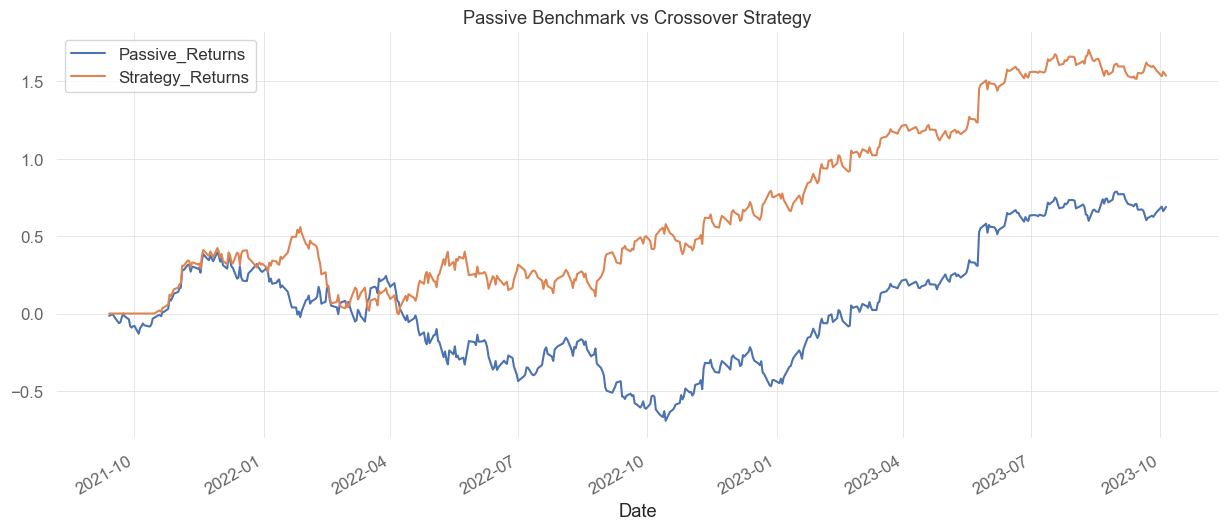

In [3]:
# 1. Define Ticker(s)
singleTicker = ["NVDA"]

# 2. Define Back Test Period
nYears = 3

# For a specific end date
# endDate = dt.datetime(2021,6,30).date()
endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Define Moving Average Time Periods
short = 8
long = 13
useExponentialAvg = True

# 4. Run Strategy
thisStrategy = MACrossOver(singleTicker, startDate, endDate, short, long, useExponentialAvg)    

# 5. Run Extra Analysis (Uncomment as Required)

#thisStrategy.show()
#thisStrategy.plot(days=100) # use days=-1 to display all
#thisStrategy.signalCount()
#thisStrategy.checkPositions(days=100)

# Optimize Strategy Parameters with Default Settings
#thisStrategy.optimize()

# Restore Strategy to Original State
#thisStrategy.restore()

# Optimize Strategy Parameters with Custom Settings
#shortDaySearchList=[2,3,4,5,6,7,8,9,10]
#longDaySearchList=[10,11,12,13,14,15,16,17,18,20,25,30,35,40,45,50]
#useOptimalParams=False
#thisStrategy.optimize(shortDaySearchList, longDaySearchList, useOptimalParams)

# Compare Vs Benchmark
thisStrategy.compare()

# Detailed Extensive Analysis
#thisStrategy.analysis()

# Run Strategy for a Ticker List

In [4]:
def runMultiStrategy(tickerList, startDate, endDate, shortDays, longDays, useExponentialAvg):
    bestTicker = ""
    bestReturn = -999
    
    for ticker in tickerList:
        
        thisStrategy = MACrossOver(ticker, startDate, endDate, shortDays, longDays, useExponentialAvg)
        thisReturn = thisStrategy.totalReturn
        
        if (thisReturn > bestReturn):
            bestTicker = thisStrategy.ticker
            bestReturn = thisReturn
            bestStrategy = thisStrategy
    
    print()
    print(f"Best Performer: {bestStrategy.ticker}")
    print(f"Total Return {bestStrategy.totalReturn}")
    
    return bestStrategy

In [5]:
# 1. Define Ticker(s)
tickerList = ["NVDA", "TSLA", "MSFT", "AAPL", "GOOG", "AMZN", "META", "BABA", "NFLX", "ADBE"]

# 2. Define Back Test Period
nYears = 3

# For a specific end date
# endDate = dt.datetime(2021,6,30).date()
endDate = date.today()
startDate = endDate - pd.Timedelta(days=nYears * 252)

# 3. Define Moving Average Time Periods
shortDays = 8
longDays = 13
useExponentialAvg = True

# 4. Run Strategy on Ticker List
bestStrategy = runMultiStrategy(tickerList, startDate, endDate, shortDays, longDays, useExponentialAvg)

[*********************100%***********************]  1 of 1 completed
NVDA Total Return:  1.54
[*********************100%***********************]  1 of 1 completed
TSLA Total Return:  1.69
[*********************100%***********************]  1 of 1 completed
MSFT Total Return:  -0.34
[*********************100%***********************]  1 of 1 completed
AAPL Total Return:  0.24
[*********************100%***********************]  1 of 1 completed
GOOG Total Return:  -0.49
[*********************100%***********************]  1 of 1 completed
AMZN Total Return:  0.19
[*********************100%***********************]  1 of 1 completed
META Total Return:  0.75
[*********************100%***********************]  1 of 1 completed
BABA Total Return:  0.51
[*********************100%***********************]  1 of 1 completed
NFLX Total Return:  0.56
[*********************100%***********************]  1 of 1 completed
ADBE Total Return:  0.13

Best Performer: TSLA
Total Return 1.69


# Perform Analysis on Best Performing Ticker

*** Searching for Optimal Results ***
ShortDays: 2, LongDays: 10, Total Return: 1.49
ShortDays: 2, LongDays: 11, Total Return: 1.59
ShortDays: 2, LongDays: 12, Total Return: 1.67
ShortDays: 2, LongDays: 13, Total Return: 1.5
ShortDays: 2, LongDays: 14, Total Return: 1.46
ShortDays: 2, LongDays: 15, Total Return: 1.54
ShortDays: 2, LongDays: 16, Total Return: 1.58
ShortDays: 2, LongDays: 17, Total Return: 1.43
ShortDays: 2, LongDays: 18, Total Return: 1.47
ShortDays: 2, LongDays: 20, Total Return: 1.52
ShortDays: 2, LongDays: 25, Total Return: 1.24
ShortDays: 2, LongDays: 30, Total Return: 1.1
ShortDays: 2, LongDays: 35, Total Return: 1.14
ShortDays: 2, LongDays: 40, Total Return: 0.8
ShortDays: 2, LongDays: 45, Total Return: 0.92
ShortDays: 2, LongDays: 50, Total Return: 0.35
ShortDays: 3, LongDays: 10, Total Return: 1.65
ShortDays: 3, LongDays: 11, Total Return: 1.94
ShortDays: 3, LongDays: 12, Total Return: 1.75
ShortDays: 3, LongDays: 13, Total Return: 1.76
ShortDays: 3, LongDays: 1

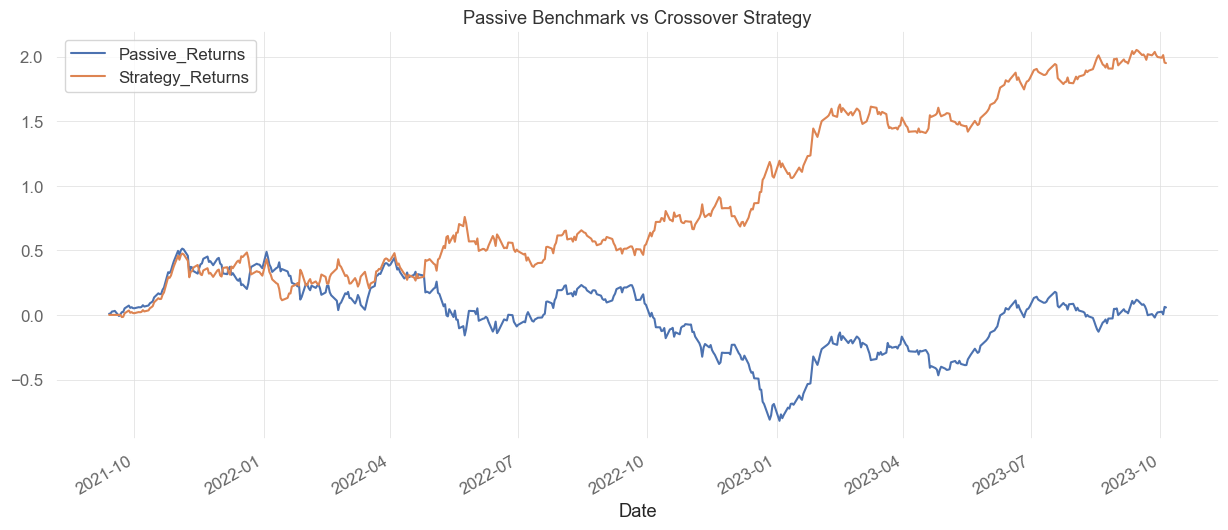

                    Strategy
------------------  ----------
Start Period        2021-09-13
End Period          2023-10-05
Risk-Free Rate      0.0%
Time in Market      99.0%

Cumulative Return   375.68%
CAGR﹪              68.64%

Sharpe              1.53
Prob. Sharpe Ratio  98.72%
Sortino             2.44
Sortino/√2          1.72
Omega               1.3

Max Drawdown        -34.29%
Longest DD Days     187

Gain/Pain Ratio     0.3
Gain/Pain (1M)      4.59

Payoff Ratio        1.11
Profit Factor       1.3
Common Sense Ratio  1.63
CPC Index           0.78
Tail Ratio          1.26
Outlier Win Ratio   3.88
Outlier Loss Ratio  2.78

MTD                 -4.78%
3M                  2.38%
6M                  54.58%
YTD                 115.25%
1Y                  219.74%
3Y (ann.)           68.64%
5Y (ann.)           68.64%
10Y (ann.)          68.64%
All-time (ann.)     68.64%

Avg. Drawdown       -9.29%
Avg. Drawdown Days  27
Recovery Factor     5.68
Ulcer Index         0.16
Serenity Index      1

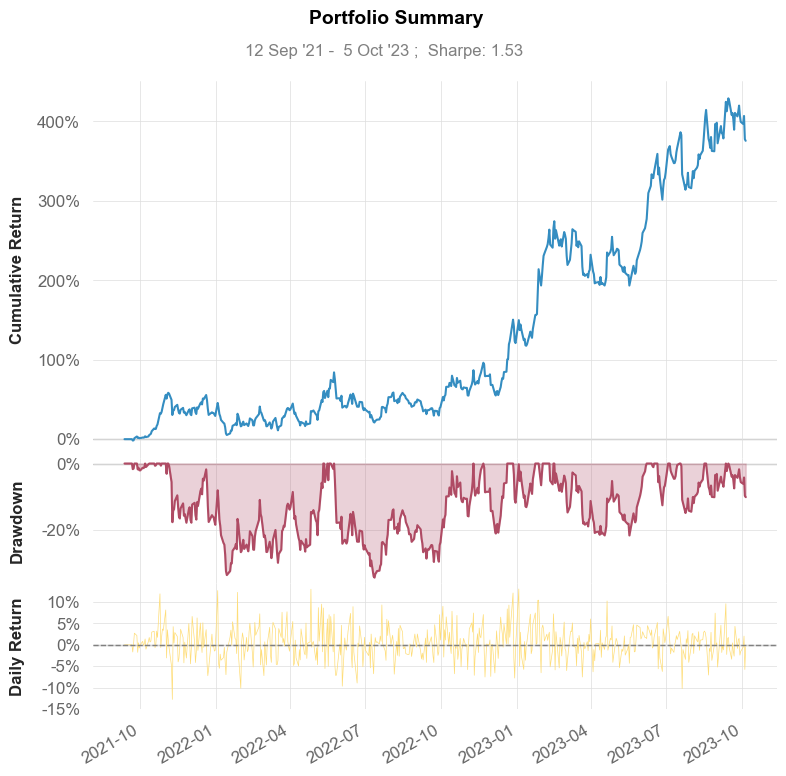

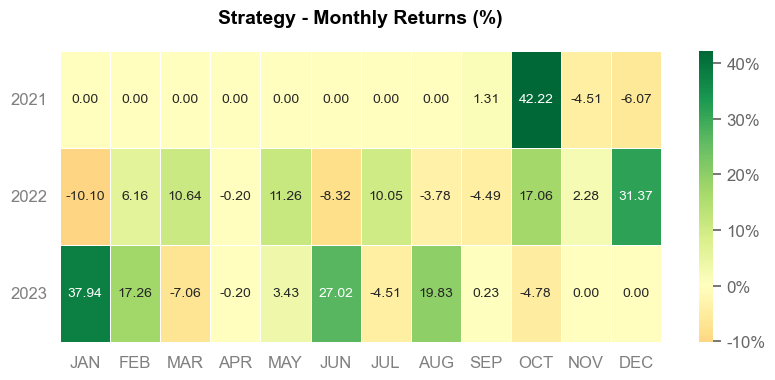

In [6]:
# Uncomment as Required

# Show Data
#bestStrategy.show()

# Plot All Data
#bestStrategy.plot(days=-1)

# Plot Data (Last 100 Days)
#bestStrategy.plot(days=100)

# Signal Count
#bestStrategy.signalCount()

# Check Positions Triggered Correctly (Last 100 Days)
#bestStrategy.checkPositions(days=100)

# Optimize Moving Average Parameters
bestStrategy.optimize()

# Restore Strategy to Pre-Optimized State
#bestStrategy.restore()

# Compare vs Benchmark
bestStrategy.compare()

# Detailed Performance Statistics and Charts
bestStrategy.analysis()